<img src="../src/packt-banner.png" alt="">

# Regression modelling of Bangladesh Incidents using ENSEMBLES
--Author:Umar Shehu

In [1]:
import pandas as pd
import numpy as np
import sklearn 
from pandas import read_excel
import numpy as np
from sklearn import preprocessing
import statsmodels.api as stat
import statsmodels.formula.api as sm
import scipy.stats as stats
import researchpy as rp
from statsmodels.formula.api import ols
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\hadoop\Anaconda6\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, sklearn, graphviz,pyodbc, mlxtend, statsmodels

Software,Version
Python,3.7.1 64bit [MSC v.1915 64 bit (AMD64)]
IPython,7.8.0
OS,Windows 10 10.0.17134 SP0
pandas,0.25.1
numpy,1.17.2
matplotlib,3.0.2
seaborn,0.9.0
sklearn,0.20.1
graphviz,The 'graphviz' distribution was not found and is required by the application
pyodbc,4.0.25


---

In [3]:
# Read file
df0 = pd.read_csv("incident-raw-data2.csv")

In [4]:
df = df0

In [5]:
df.columns

Index(['eventdate', 'eventsource', 'division', 'district', 'upazilla', 'union',
       'viol', 'vdir', 'viotypeone', 'viotypetwo', 'weaptypeone',
       'weaptypetwo', 'mtvincidentone', 'mtvincidenttwo', 'crosscutting',
       'perpgroup', 'targgroup', 'actorone', 'actortwo', 'actorone_killed',
       'actorone_injured', 'actortwo_killed', 'actortwo_injured', 'kiltotal',
       'kilfetotal', 'injtotal', 'injfetotal', 'sexasstotal', 'sexassfetotal',
       'abdtotal', 'arresttotal', 'damageproperty', 'intervention',
       'eventdesc', 'eventurl'],
      dtype='object')

In [6]:
df.isnull().sum() / len(df) * 100

eventdate            0.000000
eventsource          0.000000
division             0.000000
district             0.000000
upazilla             0.000000
union                0.855115
viol                11.821018
vdir                50.933097
viotypeone           3.156932
viotypetwo           0.505539
weaptypeone          0.000000
weaptypetwo          0.000000
mtvincidentone       0.000000
mtvincidenttwo       0.000000
crosscutting         0.000000
perpgroup            0.059159
targgroup            0.018823
actorone             0.000000
actortwo             0.008067
actorone_killed      0.000000
actorone_injured     0.000000
actortwo_killed      0.000000
actortwo_injured     0.000000
kiltotal             0.000000
kilfetotal           0.000000
injtotal             0.000000
injfetotal           0.000000
sexasstotal          0.000000
sexassfetotal        0.000000
abdtotal             0.000000
arresttotal          0.000000
damageproperty      90.932559
intervention        82.004948
eventdesc 

In [9]:
df1 = df
#Converting object datatype to datetime
df1["eventdate"] = pd.to_datetime(df1["eventdate"])
#df1["arresttotal"] = df1.arresttotal.fillna(value=0).Int()
df1["day"] = df1["eventdate"].dt.day
df1["month"] = df1["eventdate"].dt.month
df1["year"] = df1["eventdate"].dt.year
df1["weekday"] = df1["eventdate"].dt.weekday
df1["week"] = df1["eventdate"].dt.week
df1["quarter"] = df1["eventdate"].dt.quarter
## Created a new column for the total number of persons impacted (injured+killed) as per the data available
df1["total_impacted"] = df1["kiltotal"] + df1["injtotal"]

In [10]:
df1.columns

Index(['eventdate', 'eventsource', 'division', 'district', 'upazilla', 'union',
       'viol', 'vdir', 'viotypeone', 'viotypetwo', 'weaptypeone',
       'weaptypetwo', 'mtvincidentone', 'mtvincidenttwo', 'crosscutting',
       'perpgroup', 'targgroup', 'actorone', 'actortwo', 'actorone_killed',
       'actorone_injured', 'actortwo_killed', 'actortwo_injured', 'kiltotal',
       'kilfetotal', 'injtotal', 'injfetotal', 'sexasstotal', 'sexassfetotal',
       'abdtotal', 'arresttotal', 'damageproperty', 'intervention',
       'eventdesc', 'eventurl', 'day', 'month', 'year', 'weekday', 'week',
       'quarter', 'total_impacted'],
      dtype='object')

In [11]:
#set engineering feature and target variables for analysis
engfeat = 'vdir'
targt = 'total_impacted'

In [12]:
df1 = df1.fillna(value=0)

In [13]:
#filter out zeros in target variable
df1 = df1[df1[targt]!=0]
df1.shape

(18769, 42)

In [16]:
features = [
          #  'eventdate', 
    'eventsource', 
    'division', 
    'district', 
    'upazilla', 
    'union',
    'viol', 
    'vdir', 
    'viotypeone', 
    'viotypetwo', 
    'weaptypeone',
    'weaptypetwo', 
    'mtvincidentone', 
    'mtvincidenttwo', 
    'crosscutting',
    'perpgroup', 
    'targgroup', 
    'actorone', 
    'actortwo', 
    'actorone_killed',
    'actorone_injured', 
    'actortwo_killed', 
    'actortwo_injured', 
    #'kiltotal',
    #'kilfetotal', 
    #'injtotal', 
    #'injfetotal', 
    #'sexasstotal', 
    #'sexassfetotal',
    #'abdtotal', 
   # 'arresttotal', 
    #'damageproperty', 
    'intervention',
    #'eventdesc', 
    #'eventurl', 
    'day', 
    'month', 
    'year', 
    'weekday', 
    'week',
    'quarter', 
    targt,
    
           ]
df1 = df1[features]

In [17]:
#we fit a regression line using the Ordinary Least Square algorithm
import statsmodels.api as stat
import statsmodels.formula.api as sm
import scipy.stats as stats
import researchpy as rp
from statsmodels.formula.api import ols

In [18]:
df1.dtypes

eventsource          object
division             object
district             object
upazilla             object
union                object
viol                 object
vdir                float64
viotypeone           object
viotypetwo           object
weaptypeone          object
weaptypetwo          object
mtvincidentone       object
mtvincidenttwo       object
crosscutting         object
perpgroup            object
targgroup            object
actorone             object
actortwo             object
actorone_killed       int64
actorone_injured      int64
actortwo_killed       int64
actortwo_injured      int64
intervention         object
day                   int64
month                 int64
year                  int64
weekday               int64
week                  int64
quarter               int64
total_impacted        int64
dtype: object

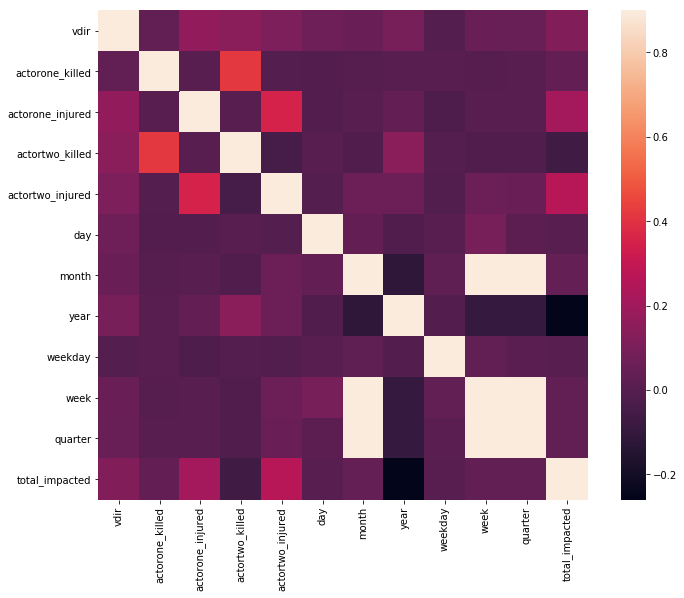

In [19]:
#data correlation
corrmat = df1.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [20]:
# split data into train and test data
msk = np.random.rand(len(df1)) < 0.8
train = df1[msk]
test = df1[~msk]
y_test = test[targt]
#drop Activity from test data
test.drop([targt], axis=1, inplace=True)

C:\Users\hadoop\Anaconda6\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
#automatically encode multiple category columns using label encoder
from sklearn.preprocessing import LabelEncoder
cols = (
        'eventsource', 'division', 'district', 'upazilla', 'union', 'viol',
       'vdir', 'viotypeone', 'viotypetwo', 'weaptypeone', 'weaptypetwo',
       'mtvincidentone', 'mtvincidenttwo', 'crosscutting', 'perpgroup',
       'targgroup', 'actorone', 'actortwo', 'actorone_killed',
       'actorone_injured', 'actortwo_killed', 'actortwo_injured',
       'intervention', 'day', 'month', 'year',
       'weekday', 'week', 'quarter'
       )



 #process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

 #shape        
print('Shape of train: {}'.format(train.shape))

C:\Users\hadoop\Anaconda6\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Shape of train: (15119, 30)


In [22]:
#automatically encode multiple category columns using label encoder
from sklearn.preprocessing import LabelEncoder
cols = (
        'eventsource', 'division', 'district', 'upazilla', 'union', 'viol',
       'vdir', 'viotypeone', 'viotypetwo', 'weaptypeone', 'weaptypetwo',
       'mtvincidentone', 'mtvincidenttwo', 'crosscutting', 'perpgroup',
       'targgroup', 'actorone', 'actortwo', 'actorone_killed',
       'actorone_injured', 'actortwo_killed', 'actortwo_injured',
       'intervention', 'day', 'month', 'year',
       'weekday', 'week', 'quarter'
       )
 #process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))

 #shape        
print('Shape test: {}'.format(test.shape))

Shape test: (3650, 29)


C:\Users\hadoop\Anaconda6\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


C:\Users\hadoop\Anaconda6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 4.87 and sigma = 13.93



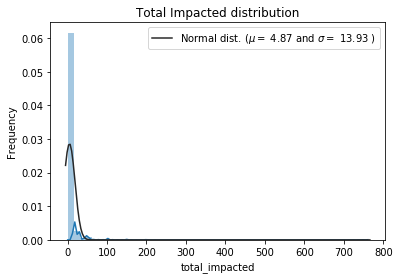

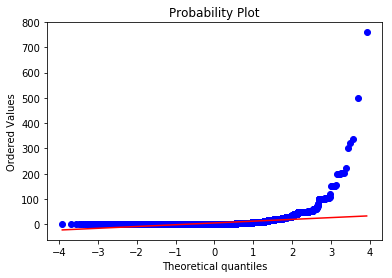

In [23]:
from scipy.stats import norm, skew
#Explore the shape of activity target variable - The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.
sns.distplot(train[targt] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[targt])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Impacted distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[targt], plot=plt)
plt.show()

C:\Users\hadoop\Anaconda6\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



 mu = 1.20 and sigma = 0.84



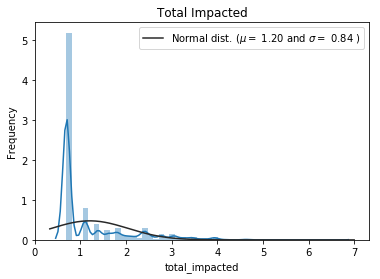

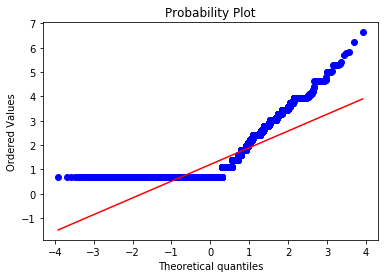

In [24]:
#Log-transformation of the train target variable
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train[targt] = np.log1p(train[targt])

#Check the new distribution 
sns.distplot(train[targt] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train[targt])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total Impacted')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train[targt], plot=plt)
plt.show()
#The skew seems now corrected and the data appears more normally distributed

In [25]:
# concatenate the train and test data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train[targt].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop([targt], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (18769, 29)


C:\Users\hadoop\Anaconda6\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [26]:
#missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [29]:
#Getting the new train and test sets.
train = all_data[:ntrain]
test = all_data[ntrain:]

In [30]:
test.head()

,actorone,actorone_injured,actorone_killed,actortwo,actortwo_injured,actortwo_killed,crosscutting,day,district,division,...,upazilla,vdir,viol,viotypeone,viotypetwo,weaptypeone,weaptypetwo,week,weekday,year
15119,0,0,0,0,0,0,3,8,11,1,...,334,1,2,3,0,2,0,27,0,0
15120,0,0,0,0,0,0,3,8,6,1,...,337,1,2,3,0,7,0,35,6,0
15121,0,0,0,0,1,0,3,15,39,4,...,335,1,2,3,0,8,0,36,6,0
15122,0,0,0,0,0,0,3,9,9,1,...,438,1,2,3,0,8,0,1,2,0
15123,0,0,0,0,0,0,3,11,47,1,...,196,1,2,3,0,1,0,49,4,1


In [31]:
train.head()

,actorone,actorone_injured,actorone_killed,actortwo,actortwo_injured,actortwo_killed,crosscutting,day,district,division,...,upazilla,vdir,viol,viotypeone,viotypetwo,weaptypeone,weaptypetwo,week,weekday,year
0,55,0,0,59,0,0,3,8,13,2,...,479,2,2,4,0,2,0,35,6,0
1,0,0,0,0,0,0,3,8,47,1,...,61,1,2,3,7,9,0,40,1,0
2,3,0,0,15,1,0,3,15,9,1,...,168,2,2,4,3,9,0,36,6,0
3,0,0,0,0,1,0,3,19,27,3,...,283,1,2,3,0,5,0,37,3,0
4,3,0,0,15,0,0,3,9,55,6,...,441,2,2,3,7,2,7,1,2,0


# Start ElasticNet Regression for Feature Importance

In [32]:
# Let's perform a cross-validation to find the best combination of alpha and l1_ratio
from sklearn.linear_model import ElasticNetCV, ElasticNet

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

In [33]:
cv_model.fit(train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1], max_iter=2000,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [34]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00001320
Optimal l1_ratio: 0.500
Number of iterations 34


In [35]:
# train model with best parameters from CV
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(train, y_train)

ElasticNet(alpha=1.3197397914894955e-05, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=34, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [36]:
# r2 score on training dataset
from sklearn import preprocessing
from sklearn.metrics import r2_score
print(r2_score(y_train, model.predict(train)))

0.454444342270513


In [37]:
print(cv_model.coef_)

[ 2.33357716e-03  4.37274549e-02  1.59625439e-01  1.77700008e-03
  7.39606882e-02 -1.29323247e-01 -4.84123313e-03 -7.07246137e-04
  6.96299487e-04  4.35302700e-03  8.31113601e-03  1.81007706e-03
 -1.38064084e-03 -4.04485771e-03  2.39910115e-03 -1.17700105e-03
 -2.57807946e-03 -2.13634989e-03  5.05796469e-05 -1.41516956e-05
  2.42798544e-01 -6.42593662e-02 -1.48081175e-02  1.71468913e-02
 -7.49776104e-03  4.96773854e-02  6.31075560e-04  2.73767781e-03
 -9.82562489e-02]


29 features, reduction of 0.00%


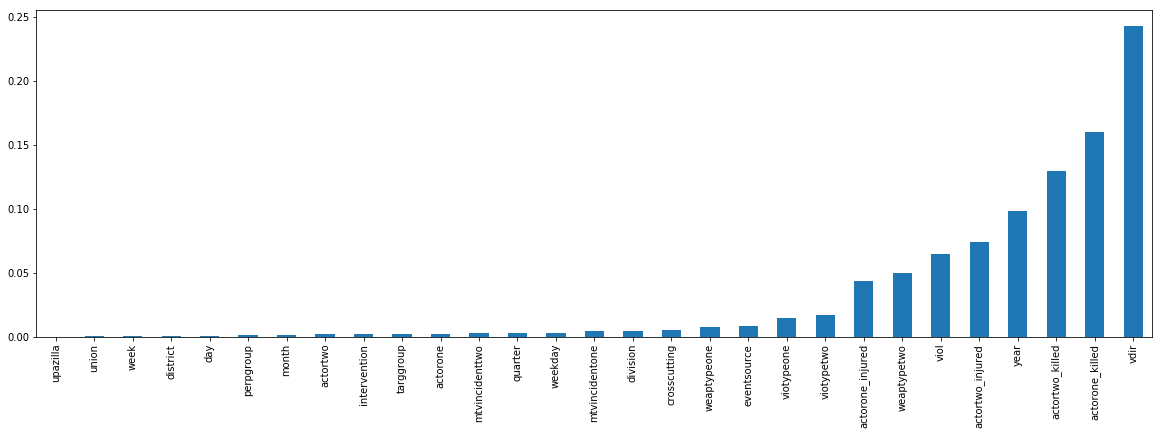

In [38]:
feature_importance = pd.Series(index = train.columns, data = np.abs(model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (20,6))

In [39]:
fs = (pd.DataFrame([feature_importance])).T
fs.to_csv('FeatureImportance.csv',index=True)


## START Stacked Regression model (Ensemble)

In [40]:
#Define a cross validation strategy
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [41]:
#LASSO Regression :
#This model may be very sensitive to outliers. So we need to make it more robust on them. 
#For that we use the sklearn's Robustscaler() method on pipeline
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#model score on our data
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




Lasso score: 0.6650 (0.2553)



In [42]:
#Elastic Net Regression : again made robust to outliers
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#model score on our data
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.6650 (0.2553)



In [43]:
#Kernel Ridge Regression: sensitive to outliers
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#model score on our data
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.6574 (0.2769)



In [44]:
#Gradient Boosting Regression : With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
#model score on our data - Slowest
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.5968 (0.2281)



In [45]:
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#model score on our data
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.5809 (0.2401)



In [46]:
#stacknet stacdking averaged models class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [47]:
#implement stacknet stacking averaged models
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

In [ ]:
#to add other models into the stacked model
#define rmsle evaluation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
#training and prediction for stackedregressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))